In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 20}

mpl.rc('font', **font)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from datetime import datetime
from timeit import timeit


from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

In [2]:
# import the Train and Test CSV files
train_data = pd.read_csv('D:/Datasets/train.csv')
test_data = pd.read_csv('D:/Datasets/test.csv')

In [3]:
# analyse the dataset: find the number of true'1'/false'0' values under each labels in the training dataset
valCount = (train_data.iloc[:, 2:8]).apply(pd.value_counts)
valCount.sort_values(by=1, ascending=True, axis=1, inplace=True)
valCount

,threat,identity_hate,severe_toxic,insult,obscene,toxic
0,159093,158166,157976,151694,151122,144277
1,478,1405,1595,7877,8449,15294


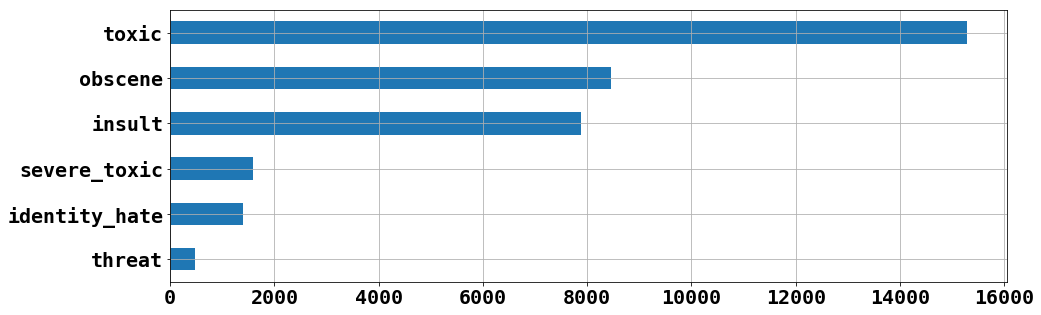

In [4]:
# plot only the true '1' values under each labels in training dataset
valCount.loc[1].plot.barh(figsize=(15,5)).grid()

In [5]:
# extract comment_text column from train and test for vectorizing
trainComTxt = train_data['comment_text']
testComTxt = test_data['comment_text']
fullTxt = pd.concat([trainComTxt,testComTxt])

In [6]:
# create pipeline for TF-IDF vectorizer and Logistic Regression class for Grid search CV
txtClf = Pipeline([('tfidfvec', TfidfVectorizer(analyzer='word',stop_words='english',use_idf=True,smooth_idf=True)),
                    ('sgdc', SGDClassifier())])

In [7]:
# set possible hyper parameters for TF-IDF and Linear Support Vector Classifier for Grid Search CV
params = {'tfidfvec__sublinear_tf': (True, False),
          'tfidfvec__ngram_range': [(1,1),(1,2)],
          'tfidfvec__max_features': (20000,30000),
          'sgdc__alpha':(0.01, 0.001),
          'sgdc__loss':('hinge','squared_hinge','perceptron')}

In [8]:
# create grid search CV object with pipeline and params
gsClf = GridSearchCV(txtClf, params, n_jobs=2)

In [9]:
#validate the training data with 20000 records
gstrain = train_data.iloc[:20000,1]
gstrain.head()
gstarget = train_data.iloc[:20000, 2:8]
gstarget.head(10)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,1,1,1,0,1,0
7,0,0,0,0,0,0
8,0,0,0,0,0,0
9,0,0,0,0,0,0


In [10]:
# labels in list for iteration
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [11]:
# Grid search CV for all label and find best score and best param for respective labels
for label in labels:
    target = gstarget[label]
    strTm = datetime.now()
    gsClf = gsClf.fit(gstrain, target)
    bestParam = gsClf.best_params_
    bestScore = gsClf.best_score_
    difTm = (datetime.now()-strTm)
    msg = "For %s, Best Params: %s and Best Score:%f, Time taken:%s sec." % (label,str(bestParam),bestScore,str(difTm.seconds))
    print msg

C:\Anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


For toxic, Best Params: {'sgdc__loss': 'perceptron', 'tfidfvec__sublinear_tf': False, 'tfidfvec__max_features': 30000, 'sgdc__alpha': 0.001, 'tfidfvec__ngram_range': (1, 1)} and Best Score:0.943200, Time taken:405 sec.
For severe_toxic, Best Params: {'sgdc__loss': 'perceptron', 'tfidfvec__sublinear_tf': True, 'tfidfvec__max_features': 30000, 'sgdc__alpha': 0.01, 'tfidfvec__ngram_range': (1, 1)} and Best Score:0.989900, Time taken:361 sec.
For obscene, Best Params: {'sgdc__loss': 'perceptron', 'tfidfvec__sublinear_tf': True, 'tfidfvec__max_features': 30000, 'sgdc__alpha': 0.001, 'tfidfvec__ngram_range': (1, 1)} and Best Score:0.973850, Time taken:386 sec.
For threat, Best Params: {'sgdc__loss': 'perceptron', 'tfidfvec__sublinear_tf': True, 'tfidfvec__max_features': 30000, 'sgdc__alpha': 0.01, 'tfidfvec__ngram_range': (1, 1)} and Best Score:0.996850, Time taken:359 sec.
For insult, Best Params: {'sgdc__loss': 'perceptron', 'tfidfvec__sublinear_tf': False, 'tfidfvec__max_features': 30000,

In [12]:
# TFidf vectorizer with best param identified from Grid search CV
tfIdf = TfidfVectorizer(smooth_idf=True, sublinear_tf=True, analyzer='word', use_idf=True, 
                        ngram_range=(1, 1), stop_words="english", max_features=30000)

In [13]:
# Fit and Tranform comment texts into TF-IDF vectors for train and test data
tfIdf.fit(fullTxt)
trainFeat = tfIdf.transform(trainComTxt)
testFeat = tfIdf.transform(testComTxt)

In [14]:
trainFeat.shape

(159571, 30000)

In [15]:
testFeat.shape

(153164, 30000)

In [16]:
# Cross validation of with training data with roc_auc scoring with Linear Support Vector Classifier parameter identified by Grid Search CV
for label in labels:
    trainTarg = train_data[label]
    cv = cross_val_score(SGDClassifier(loss='perceptron', alpha=0.001), trainFeat, train_data[label], cv=10, scoring='roc_auc')
    score = cv.mean()
    msg = "%s: %f" % (label, score)
    print msg

toxic: 0.940359
severe_toxic: 0.929644
obscene: 0.957593
threat: 0.953592
insult: 0.933088
identity_hate: 0.928112


In [17]:
# create a dataframe store predicted probabilities
predResults = pd.DataFrame.from_dict({'Comment': test_data['comment_text']})

In [18]:
# Using Linear Support Vector Classifier model, fitting the training data for all labels & predicting probabilities, using Calibrated Classifier, for test data
for label in labels:
    trainTarg = train_data[label]
    lSVCcClf = CalibratedClassifierCV(base_estimator=SGDClassifier(loss='perceptron', alpha=0.001), cv=10)
    lSVCcClf.fit(trainFeat,trainTarg)
    predResults[label] = lSVCcClf.predict_proba(testFeat)[:,1]
    debugMsg = "Prediction completed for %s label" %label
    print debugMsg

Prediction completed for toxic label
Prediction completed for severe_toxic label
Prediction completed for obscene label
Prediction completed for threat label
Prediction completed for insult label
Prediction completed for identity_hate label


In [19]:
# validate size of predicted results
predResults.shape

(153164, 7)

In [20]:
predResults.head()

,Comment,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Yo bitch Ja Rule is more succesful then you'll...,0.991024,0.100031,0.993525,0.045906,0.727691,0.145954
1,== From RfC == \n\n The title is fine as it is...,0.005688,0.001311,0.001440,0.000276,0.013155,0.001922
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0.022558,0.001074,0.005324,0.000099,0.014831,0.001765
3,":If you have a look back at the source, the in...",0.004583,0.057727,0.014222,0.000697,0.022079,0.000258
4,I don't anonymously edit articles at all.,0.007992,0.002290,0.003398,0.001058,0.003694,0.001180


In [21]:
# save the predicted results as csv file
predResults.to_csv('sdgc_Prediction.csv',index=False)